# Introduction

The goal of this notebook is to use data to understand the relationship that age and weight play in developing hypertension. The type of data you plan on using heavily influences the type of algorithm that's available to use. Additionally, it's usually a good idea to visualize the data before making any decision about what kind of algorithm would be appropriate.

First, let's import the necessary modules and then read in the data.

## Imports

In [2]:
# For manipulating data
import pandas as pd

# For plotting graphs
import matplotlib.pyplot as plt

# For constructing the model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# For evaluating model performance
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Read Data

In [3]:
dataset_url = "https://raw.githubusercontent.com/papir805/Stanford-ML-Class/master/data/blood_pressure_data.csv"

# Load the data set.  Use the CSV's first column as the dataframe's index
df = pd.read_csv(dataset_url, index_col=0)

# Check data loaded correctly
df.head()

,age (yrs),weight (lbs),hypertension
0,23.033069,221.342609,yes
1,43.830753,205.539828,yes
2,40.573859,162.209785,no
3,66.677104,206.555090,yes
4,70.927228,177.518147,yes


In [4]:
# Store label names for x and y
x_label = 'age (yrs)'
y_label = 'weight (lbs)'

# Store target label name
target_label = 'hypertension'

# Extract unique target labels
label_0 = 'yes'
label_1 = 'no'

## Visualize The Dataset

In [5]:
# Assign colors based on target_label for visualization
df['color'] = df[target_label].map({label_0:'green', label_1:'red'})

# Seperate the data on patients with hypertension
# from those without
df_yesses = df[df[target_label]==label_0]
df_nos = df[df[target_label]==label_1]

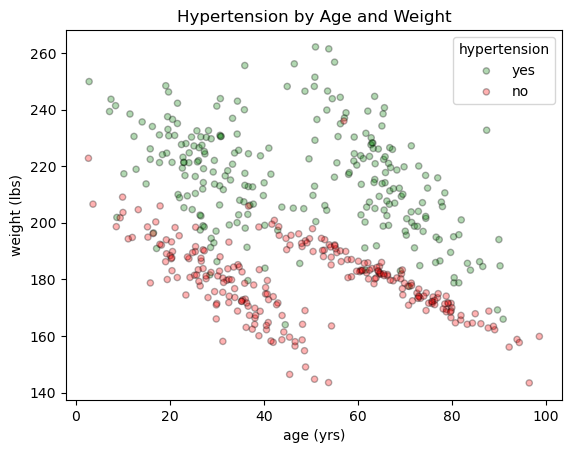

In [6]:
# Create figure and axis for graphing
fig, ax = plt.subplots(1,1)

# Scatter plot of patients with hypertension
ax.scatter(x=df_yesses[x_label], 
           y=df_yesses[y_label],
           c=df_yesses['color'],
           label=label_0, s=20, 
           edgecolor="k", alpha=0.3)

# Scatter plot of patients without hypertension
ax.scatter(x=df_nos[x_label], 
           y=df_nos[y_label], 
           c=df_nos['color'],
           label=label_1, s=20, 
           edgecolor="k", alpha=0.3)

ax.set_title('Hypertension by Age and Weight')
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend(title=target_label)

plt.show()

It appeares that most people who are over about 200 lbs have hypertension.  However, that number trends downward over time.  After about age 60, most people over 180 lbs have hypertension.  Young people and people who weigh less represent the vast majority of those withougt hyptertension.

# Why k-Nearest Neighbors (kNN)?

k-Nearest Neighbors is another statistical tool to help understand relationships between data by comparing the "closeness" of observations in the dataset.  kNN regression can be used to predict a quantitative output whereas kNN classification can predict a qualitative output.

In this example, the goal is to predict a qualitative output, whether someone has hypertension, so kNN classification will be used.

**Note**: Using qualitative inputs involves a little more effort than quantitative inputs.  This notebook will first consider the simplest case, when only quantitative inputs are used (age and weight). However, sections will be added to the notebook later to discuss how to deal with more complex situations.

# Generate Training and Testing Data

While not true in all circumstances, the goal of many ML algorithms is to use the algorithm on new and unseen data at some point.  For this reason, it's important to test the algorithm on unseen data in order to verify its performance and evaluate whether or not it will be worthwhile to use.  

This leaves two options:
* Option 1: Build the model now and wait for a sufficient amount of new data to come in, which can be used to verify the model's accuracy.
* Option 2: Parition the dataset into a training set and a testing set.  The training set can be used to build the model and the testing set will only be used to verify the accuracy.

Some may be concerned that partioning your dataset and only using part of it to build the model might negatively affect its performance.  After all, it's reasonable to think that the more data points you have the better off it will be, yet in truth there tend to be diminishing returns.  As it turns out, as long as your dataset is sufficiently large, performing a train/test split will still yield quite good results.  Given the alternative is waiting, a train/test split approach is preferred because it will allow you to determine performance immmediately and tweaks to the model can be implemented quickly, if need be.

In [7]:
# Separate feature names
feat_names = [x_label, y_label]

# Extract unique class labels
unique_labels = df[target_label].unique()

In [8]:
# Split dataset into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(df[feat_names],
                                                    df[target_label],
                                                    test_size=0.25,
                                                    random_state=42)

## Scaling the Training and Testing Data

Because kNN uses the "closeness," or in other words, the distance between two observations to make predictions, the algorithm is sensitive to differences in magnitude from one input to another.  For instance, if your x-values range from 0 - 100, while the y-values range from 0 - 1,000,000, then the distance between observations will be heavily skewed by the larger y-values.  This could lead to the biased predictions from the model.

To fix this issue, we can re-center the data to have mean 0 and re-scale it to have a standard deviation of 1.

In [9]:
# Create scaler object
scaler = StandardScaler().set_output(transform="pandas")

# Scale X inputs to have a mean of 0 and std dev of 1
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Training the kNN Classification Model

In [10]:
# Create kNN classifier object
k_neighbors_classifier = KNeighborsClassifier()

# Train the model using the training dataset
k_neighbors_classifier = k_neighbors_classifier.fit(X_train_scaled, y_train)

# The number of neighboring points used by the algorithm to predict
# a new observation
n_neighbors = k_neighbors_classifier.n_neighbors
print(f"Neighboring points used to classify new observations: {n_neighbors}")

Neighboring points used to classify new observations: 5


kNN works by calculating the distance between a new observation and *every* observation in the training set.  Once these distances are calculated, the algorithm ranks them in order, starting with the smallest distances.  With n_neighbors set to 5, the kNN algorithm will use the top 5 closest distances when making its predictions.  More on this later.

# Evaluating Model Performance - Testing Data

kNN compares the distance between a new observation and all the observations present in the training dataset.  Focusing on two observations from the testing set, we can gain insight into how kNN works.

In [11]:
# Create copy of X_train data
X_train_copy = X_train.copy(deep=True)

# Assign hypertension labels
X_train_copy[target_label] = y_train

# Assign colors
colors = []
for y in y_train:
    if y == label_0:
        colors.append('green')
    else:
        colors.append('red')
X_train_copy['color'] = colors

# Separate patients with hypertension from patients without 
train_yesses = X_train_copy[X_train_copy[target_label]==label_0]
train_nos = X_train_copy[X_train_copy[target_label]==label_1]

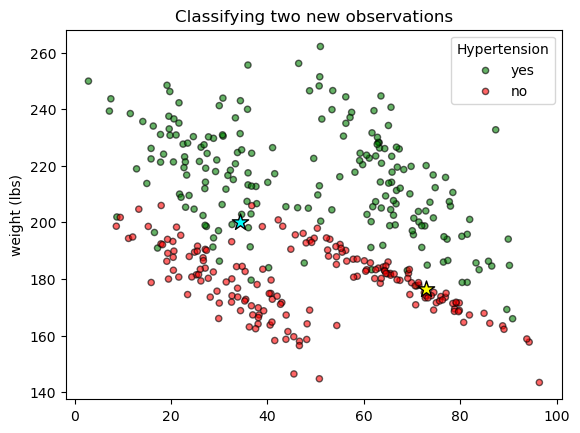

In [18]:
# Create figure and axis for graphing
fig, ax = plt.subplots(1,1)

# Scatter plot of patients with hypertension
ax.scatter(x=train_yesses[x_label], 
           y=train_yesses[y_label], 
           c=train_yesses['color'], 
           s=20, edgecolor="k", label=label_0, alpha=0.6)

# Scatter plot of patients without hypertension
ax.scatter(x=train_nos[x_label],
           y=train_nos[y_label],
           c=train_nos['color'], 
           s=20, edgecolor="k", label=label_1, alpha=0.6)

# New observation 1
ax.scatter(x=X_test.iloc[0,0],
           y=X_test.iloc[0,1],
           c='yellow', ec='black', marker='*', s=150)

# New observation 2
ax.scatter(x=X_test.iloc[10,0],
           y=X_test.iloc[10,1],
           c='cyan', ec='black', marker='*', s=150)

ax.set_title('Classifying two new observations')
ax.set_ylabel(y_label)
ax.legend(title='Hypertension')

#plt.tight_layout()
plt.show()

It's rather easy to see that the yellow star (new observation 1) is surrounded predominantly by red data points.  This indicates that patient is most similar to other patients without hypertension, and it would be reasonable to predict they would not have hypertension as well.  Looking at the blue star (new observation 2), one can see it's most similar to patients with hypertension and thus it's reasonable to predict they would also have hypertension.  

These visual comparisons are easy to do for a human, but it's a little more difficult as a computer.  Instead of measuring distance visually, the kNN algorithm calculates the distance between a new observation and *every* other observation in the dataset.  It then ranks the distances in ascending order (low -> high) and looks at the k closest observations, otherwise known as the k nearest neighbors.  The algorithm uses the labels of these already existing observations to classify new observations based on a majority vote.  

In this example, $k=5$, so if the majority of the 5 already existing observations closest to the new one have hypertension, then the new observation is predicted to have hypertension too.  If the majority have no hypertension, then the new observation is predicted to have no hypertension as well.  

## Making Predictions

In [13]:
# Make predictions using the already seen training data
predictions = k_neighbors_classifier.predict(X_test_scaled)
probabilities = k_neighbors_classifier.predict_proba(X_test_scaled)

results_df = pd.DataFrame({x_label:X_test[x_label],
                           y_label:X_test[y_label],
                         #'prob of no':probabilities[:,0],
                           'prob of hypertension':probabilities[:,1],
                           'predicted hypertension':predictions,
                           'actual hypertension': y_test})
results_df.head()

,age (yrs),weight (lbs),prob of hypertension,predicted hypertension,actual hypertension
361,72.928468,176.584205,0.2,no,no
73,60.772587,182.983672,0.0,no,no
374,68.257843,180.532871,0.4,no,no
155,58.012085,217.116597,1.0,yes,yes
104,62.101226,185.872842,0.4,no,no


Looking at the top row of the results_df, the model predicts the probability of that observation having hypertension as 0.2 or 1/5.  Remembering k_neighbors is set to 5, this is because only one of the 5 closest neighboring observations had hypertension while the remaining 4 did not.  Consequently, the model predicts the new observation will not have hypertension based on a majority "vote" of the closest 5 neighbors.

The fourth row of the results_df shows a predicted probability of hypertension as 1.0 or 5/5.  This means that the 5 observations closest to the new one, all had hypertension, and the model uses the results of its majority "vote" to label the new observation as having hypertension. 

## Checking Accuracy

Predicting a qualitative output is commonly referred to as a classification problem.  In this example, the goal is to classify a patient as either having hypertension or not based on age and weight.  The most common metric for evaluating performance is known as accuracy, which represents the percentage of predictions that were correct:

$$\text{accuracy}=\frac{n \text{ correct predictions}}{m \text{ total predictions}}$$ 

In [14]:
accuracy = k_neighbors_classifier.score(X_test_scaled, y_test)
accuracy

0.928

The model has high accuracy on testing data, correctly predicting when a patient has hypertension 92.8% of the time.  The model appears to do well on unseen data, giving confidence that it generalizes to new data well.

## Visualizing Decision Boundaries

The decision boundary represents the boundary between the algorithm predicting one label versus another.  Depending on what side of the boundary an observation is on, the algorithm will predict the label corresponding to that side.

In [15]:
# Create copy of X_test data
X_test_copy = X_test_scaled.copy(deep=True)

# Assign hypertension labels
X_test_copy[target_label] = y_test

# Assign colors
colors = []
for y in y_test:
    if y == label_0:
        colors.append('green')
    else:
        colors.append('red')
X_test_copy['color'] = colors

# Separate patients with hypertension from patients without 
test_yesses = X_test_copy[X_test_copy[target_label]==label_0]
test_nos = X_test_copy[X_test_copy[target_label]==label_1]

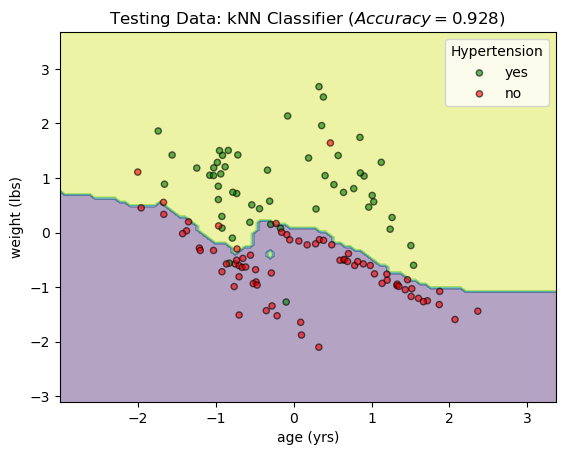

In [16]:
# Create figure and axis for graphing
fig, ax = plt.subplots(1,1)

# Draw the model's decision boundary, a boundary separating
# where it predicts hypertension from non-hypertension
DecisionBoundaryDisplay.from_estimator(estimator=k_neighbors_classifier, 
                                       X=X_test_scaled, 
                                       alpha=0.4, 
                                       response_method="predict", 
                                       ax=ax)

# Scatter plot of patients with hypertension
ax.scatter(x=test_yesses[x_label], 
           y=test_yesses[y_label], 
           c=test_yesses['color'], 
           s=20, edgecolor="k", label=label_0, alpha=0.6)

# Scatter plot of patients without hypertension
ax.scatter(x=test_nos[x_label],
           y=test_nos[y_label],
           c=test_nos['color'], 
           s=20, edgecolor="k", label=label_1, alpha=0.6)

ax.set_title(f'Testing Data: kNN Classifier $(Accuracy = {accuracy:.3f})$')
ax.set_ylabel(y_label)
ax.legend(title='Hypertension')

#plt.tight_layout()
plt.show()

The purple area of the graph corresponds to where k-Nearest Neighbors would predict no hypertension, whereas the yellow region corresponds to predicting hypertension.  Note that there are actually two yellow regions, the large region that takes up roughly the top half of the graph, and a small circular region below that's within the much larger purple region.  

Observations that had no hypertension are represented by the red dots, and most of them fall in the purple region.  This is good, these are correct predictions.  There are a few green dots in the purple region, though, representing people that had hypertension, yet were predicted by the model to have no hypertension. There are incorrect predictions.  In the yellow region, most of the dots are green, representing correct predictions, and there are a few red dots, representing incorrect predictions. 

Overall, the model is doing reasonably well at predicting hypertension correctly.

## Confusion Matrix

A confusion matrix helps get a slightly better picture of the model's predictive accuracy.  It enables one to see how many correct and incorrect predictions occurred.

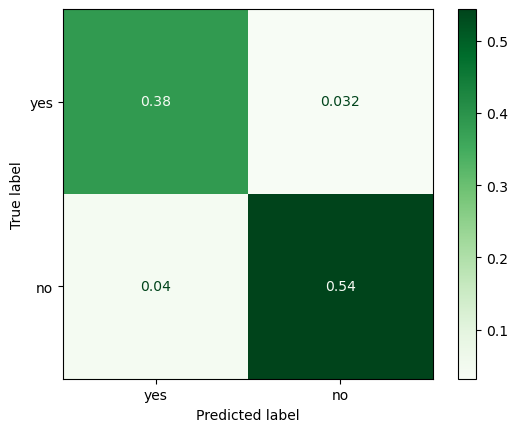

In [17]:
# Create confusion matrix object
cm = confusion_matrix(y_true=y_test, 
                      y_pred=predictions,
                      labels=unique_labels,
                      normalize='all')

# Create confusion matrix display object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                    display_labels=unique_labels)

# Graph confusion matrix display
cm_display.plot(cmap='Greens')

plt.show()

The confusion matrix further breaks down the accuracy score shown earlier.  It shows the model correctly predicts hypertension failure 38% of the time and correctly predicts no hypertension 54% of the time, giving a total of 92% accuracy.  Furthermore, the model incorrectly predicts hypertension 4% of the time and incorrectly predicts no hypertension 3.2% of the time.

# Conclusion

By visualizing the dataset, it was clear that some kind of relationship existing between age and weight and whether or not a patient had hypertension.  kNN classification was able to pick up on this relationship and performed reasonably well on testing data, with an overall predictive accuracy of 92.8%.